# <center> Проект: Анализ вакансий из HeadHunter
   

In [53]:
import pandas as pd
import numpy as np
import psycopg2
import plotly.express as px

In [54]:
px_mode = 'png'

In [55]:
conn = psycopg2.connect(
    dbname = 'project_sql',
    user = 'skillfactory',
    password = 'put correct password here...',
    host = '84.201.134.129',
    port = 5432
)

In [56]:
import warnings

# На момент работы над данным ноутбуом
# вызов метода pd.read_sql_query() сопровождался
# выводом предупреждения о поддержке объектов DBAPI2.
# Чтобы не перегружать ноутбук этим сообщением,
# вместо прямого вызова pd.read_sql_query() используем следующую функцию:
def pd_read_sql_query(sql, conn):
    with warnings.catch_warnings(): # Отключим назойливый warning
        warnings.simplefilter('ignore')
        return pd.read_sql_query(sql, conn)

## Юнит 3. Предварительный анализ данных

### 3.1. Запрос для подсчета количества вакансий в нашей базе (вакансии находятся в таблице vacancies)

In [57]:
sql = '''
    select count(*)
    from vacancies
    '''
df = pd_read_sql_query(sql, conn)
print("Количество вакансий в базе:", df.iloc[0, 0])

Количество вакансий в базе: 49197


### 3.2. Запрос для подсчета количества работодателей (таблица employers)

In [58]:
sql = '''
    select count(*)
    from employers
    '''
df = pd_read_sql_query(sql, conn)
print("Количество работодателей:", df.iloc[0, 0])

Количество работодателей: 23501


### 3.3. Запрос для подсчета количества регионов (таблица areas)

In [59]:
sql = '''
    select count(*)
    from areas
    '''
df = pd_read_sql_query(sql, conn)
print("Количество регионов:", df.iloc[0, 0])

Количество регионов: 1362


### 3.4. Запрос для подсчета количества сфер деятельности в базе (таблица industries)

In [60]:
sql = '''
    select count(*)
    from industries
    '''
df = pd_read_sql_query(sql, conn)
print("Количество сфер деятельности:", df.iloc[0, 0])

Количество сфер деятельности: 294


***

### Выводы по результатам предварительного анализа данных
В результате предварительного анализа данных получена информацмя лишь о количестве записей, хранящихся в таблицах БД.

Учитывая ограниченность полученной информации, можно сделать следующие простейшие выводы:
* **Существуют работодатели, опубликовавшие более одной вакансии в одном или нескольких регионах**
* **Существуют регионы, для которых опубликовано более одной вакансии**
* **Существуют регионы, вакансии в которых опубликованы более, чем одним работодателем**

Конечно, к таким выводам можно прийти из простого здравого смысла, не пребегая к какому-либо анализу данных.

## Юнит 4. Детальный анализ вакансий

### 4.1. Запрос для определения количества вакансий в каждом регионе

In [61]:
# Топ-20 регионов по количеству вакансий
sql = '''
    select
        a.name as area,
        count(v.id) as vacancies_count
    from
        areas as a
        join vacancies as v on v.area_id = a.id
    group by
        a.id
    order by vacancies_count desc
    limit 20
    '''
df = pd_read_sql_query(sql, conn)
display(df)
    

,area,vacancies_count
0,Москва,5333
1,Санкт-Петербург,2851
2,Минск,2112
3,Новосибирск,2006
4,Алматы,1892
5,Екатеринбург,1698
6,Нижний Новгород,1670
7,Казань,1415
8,Краснодар,1301
9,Самара,1144


### 4.2. У какого количества вакансий заполнено хотя бы одно из двух полей с зарплатой

In [62]:
sql = '''
    select count(*)
    from vacancies
    where salary_from is not null or salary_to is not null
    '''
df = pd_read_sql_query(sql, conn)
print(f"У {df.iloc[0, 0]} вакансий заполнено хотя бы одно из двух полей с зарплатой")

У 24073 вакансий заполнено хотя бы одно из двух полей с зарплатой


### 4.3. Средние значения для нижней и верхней границы зарплатной вилки

In [63]:
sql = '''
    select
        round(avg(salary_from)) as mean_lower_bound,
        round(avg(salary_to)) as mean_upper_bound
    from vacancies
    '''
pd_read_sql_query(sql, conn)

,mean_lower_bound,mean_upper_bound
0,71065.0,110537.0


### 4.4. Количество вакансий для каждого сочетания типа рабочего графика (schedule) и типа трудоустройства (employment), используемого в вакансиях


In [64]:
sql = '''
    select schedule, employment, count(*)
    from vacancies
    group by schedule, employment
    order by 3 desc
    '''
df = pd_read_sql_query(sql, conn).head(20)
display(df)

,schedule,employment,count
0,Полный день,Полная занятость,35367
1,Удаленная работа,Полная занятость,7802
2,Гибкий график,Полная занятость,1593
3,Удаленная работа,Частичная занятость,1312
4,Сменный график,Полная занятость,940
5,Полный день,Стажировка,569
6,Вахтовый метод,Полная занятость,367
7,Полный день,Частичная занятость,347
8,Гибкий график,Частичная занятость,312
9,Полный день,Проектная работа,141


### 4.5. Категории требуемого опыта работы (experience) 
(в порядке возрастания количества вакансий, в которых указан данный вариант опыта)

In [65]:
sql = '''
    select experience, count(*) as vacancies_count
    from vacancies
    group by experience
    order by 2 asc
    '''
df = pd_read_sql_query(sql, conn)
display(df)

,experience,vacancies_count
0,Более 6 лет,1337
1,Нет опыта,7197
2,От 3 до 6 лет,14511
3,От 1 года до 3 лет,26152


### 4.6. Дополнительные исследования

#### 4.6.1. Средняя заработная плата по регионам

По аналогии с первой частью проекта (анализ резюме) категоризируем регионы публикации вакансий: Москва, Санкт-Петербург, города-милионники, другие.

Сначала подготовим список городов-милионников:

In [66]:
import requests
from bs4 import BeautifulSoup

# Получим содержимое интернет-страницы, на которой есть таблица с городами-милионниками
url = 'https://ru.wikipedia.org/wiki/Города-миллионеры_России#Список_городов-миллионеров'
response = requests.get(url)

# С помощью инспектора контента в браузере заранее выяснили, 
# под каким тегом и классом находится нужная нам таблица с названиями городов.
# Названия городов даны в виде ссылок и отмечены тегом <a>.
# Используя свойство названия города, заключающееся в том, что имя собсвтенное
# начинается с заглавной буквы, отфильтруем "мусорную" информацию
page = BeautifulSoup(response.text, 'html.parser')
mln_cities = list(a.text for a in page.find('table', class_="standard sortable").find_all('a')  if a.text[0].isupper())

# Исключим из списка Москву и Питер (они пойдут отдельными категориями)
mln_cities.remove('Москва')
mln_cities.remove('Санкт-Петербург')
print("Перечень городов-миллионников, полученный из веб-страницы:")
display(mln_cities)

Перечень городов-миллионников, полученный из веб-страницы:


['Новосибирск',
 'Екатеринбург',
 'Казань',
 'Нижний Новгород',
 'Красноярск',
 'Челябинск',
 'Самара',
 'Уфа',
 'Ростов-на-Дону',
 'Омск',
 'Краснодар',
 'Воронеж',
 'Пермь',
 'Волгоград']

Теперь получим данные из базы: извлекаем записи из таблицы вакансий информацию о заработной плате и добавляем к каждой записи название региона:

In [67]:
sql = '''
    select
        v.name as vacancy,
        coalesce((v.salary_from + v.salary_to) / 2, v.salary_from, v.salary_to) as "Заработная плата",
        a.name as Регион,
        v.schedule as "График", 
        v.employment as "Тип занятости", 
        v.experience as "Требуемый опыт"
    from
        areas as a
        join vacancies as v on v.area_id = a.id
    where
        salary_from is not null or salary_to is not null
    order by 1 asc
    '''
df_salary = pd_read_sql_query(sql, conn)    

Взглянем на гистограмму заработной платы, чтобы принять решение об удалении явных аномалий:

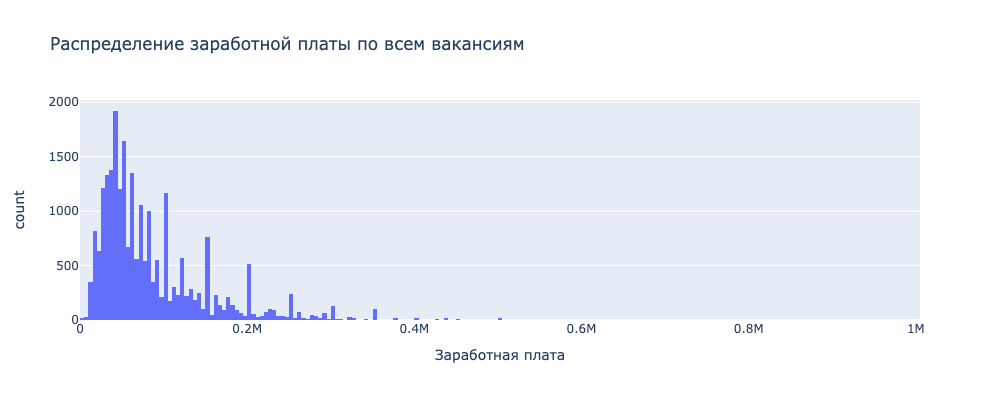

In [68]:
fig = px.histogram(
    df_salary,
    x='Заработная плата',
    title='Распределение заработной платы по всем вакансиям',
    width=1000,
    height=400
)
fig.show(px_mode)

Итак, не будем рассматривать вакансии с указанной заработной платой ниже 10 и "пеньки" выше 500 тыс.руб.

In [69]:
mask = (df_salary['Заработная плата'] >= 10_000) & (df_salary['Заработная плата'] <= 500_000)
df_salary = df_salary[mask]

Выполним категоризацию признака *'Регион'*:

In [70]:
def cat_region(x: str) ->str:
    if x in ['Москва', 'Санкт-Петербург']:
        return x
    if x in mln_cities:
        return 'город-милионник РФ'
    return 'другой'

df_salary['Регион'] = df_salary['Регион'].apply(cat_region).astype('category')

Теперь получим значения средней и медианной заработной платы в разрезе категоризированного признака региона:

In [71]:
df_grouped = df_salary.groupby('Регион')['Заработная плата'].agg(['mean', 'median']).round()
df_grouped

,mean,median
Регион,,
Москва,132105.0,110000.0
Санкт-Петербург,103370.0,80000.0
город-милионник РФ,89466.0,67500.0
другой,73620.0,50880.0


Итак, наибольшие заработные платы работодатели обещают соискателям в Москве, затем со значительным отставанием следует Санкт-Перербург. Далее идут города-милионники. И самый низкий показатель у вакансий в городах, отнесенных к категории "другие".

Следует обратить внимание на то, что во всех регионах **средняя заработная плата значительно превосходит медианную**. Принято считать, что это говорит о большом числе выбросов ("слишком" высокие зарплаты). Однако в нашем случае причины этого могут заключаться в следующем:
* медиана и среднее для зарплаты  посчитаны без учета важнейшего параметра - опыта работы: незначительное количество высоких зарплат для специалистов с большим опытом и руководителей "тянет" среднее вверх от медианы. 
* заработная плата прежде всего зависит от самой специальности (которая также не учитывалась в расчете), кадровой политики компании, типа трудоустройства и др.

#### 4.6.2. Средняя заработная плата для различных комбинаций рабочего графика и опыта работы
В предыдущем пункте (4.6.1) мы уже подготовили датафрейм со всей необхоимой информацией:

In [72]:
df_salary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24009 entries, 0 to 24072
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   vacancy           24009 non-null  object  
 1   Заработная плата  24009 non-null  int64   
 2   Регион            24009 non-null  category
 3   График            24009 non-null  object  
 4   Тип занятости     24009 non-null  object  
 5   Требуемый опыт    24009 non-null  object  
dtypes: category(1), int64(1), object(4)
memory usage: 1.1+ MB


Посмотрим на количество вакансий по категориям интересующих нас признаков:

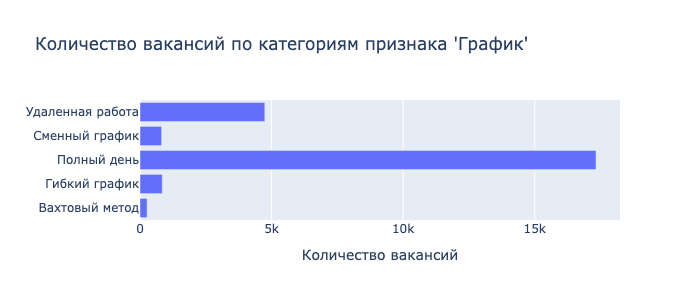

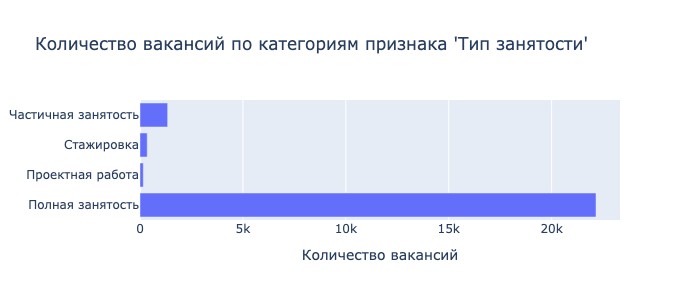

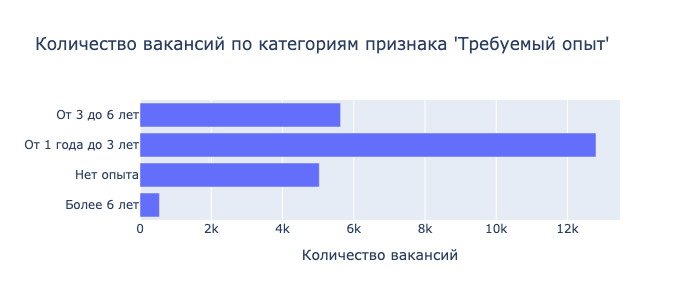

In [73]:
for col in ['График', 'Тип занятости', 'Требуемый опыт']:
    fig = px.bar(
        df_salary.groupby(col)['Заработная плата'].count(), 
        x='Заработная плата',
        width=700,
        height=300,
        labels={'Заработная плата': 'Количество вакансий', col: ''},
        title=f"Количество вакансий по категориям признака '{col}'"
    )
    fig.update_layout(margin=dict(autoexpand=False, l=140))
    fig.show(px_mode)

Исключим из рассмотрения категории *'Стажировка'* и *'Проектная работа'* (из признака *'Тип занятости'*), а также категорию *'Вахтовый метод'* (из признака *'График'*) ввиду их незначительного присутвтия в исследуемой выборке.

Также не будем рассматривать категорию *'Частиная занятость'*: заработная плата в данной категории сильно зависит от ряда параметров (например, доля ставки, о которой нам ничего не известно), изучение которых выходит за рамки данного проекта.

In [74]:
mask = (df_salary['Тип занятости'] != 'Стажировка') \
    & (df_salary['Тип занятости'] != 'Проектная работа') \
    & (df_salary['Тип занятости'] != 'Частичная занятость') \
    & (df_salary['График'] != 'Вахтовый метод')
df_salary = df_salary[mask]

Для удобства работы категоризируем призаки:

In [75]:
for col in ['График', 'Тип занятости', 'Требуемый опыт']:
    df_salary[col] = df_salary[col].astype('category')

Посмотрим на распределения заработной платы в разрезе интересующих нас признаков и категорий внутри них:

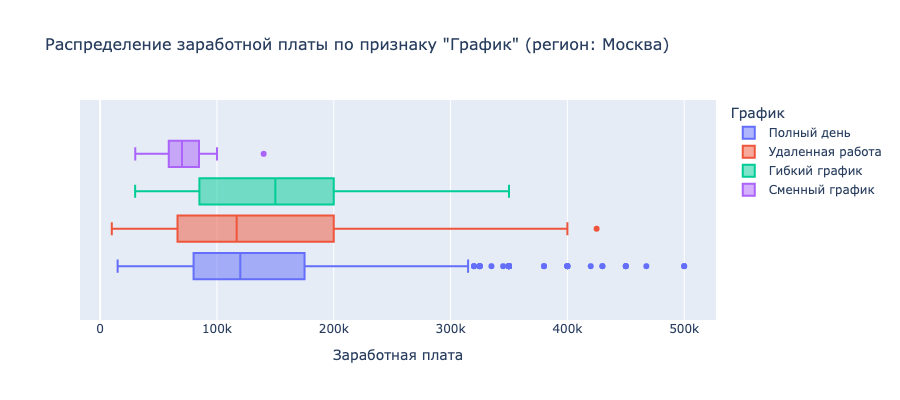

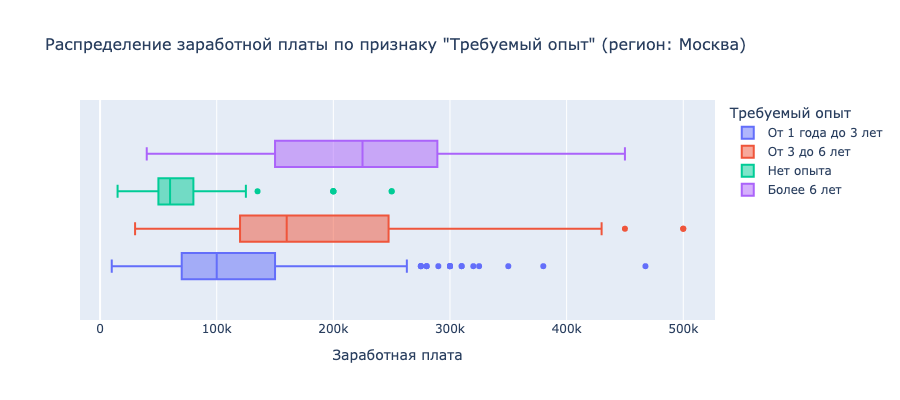

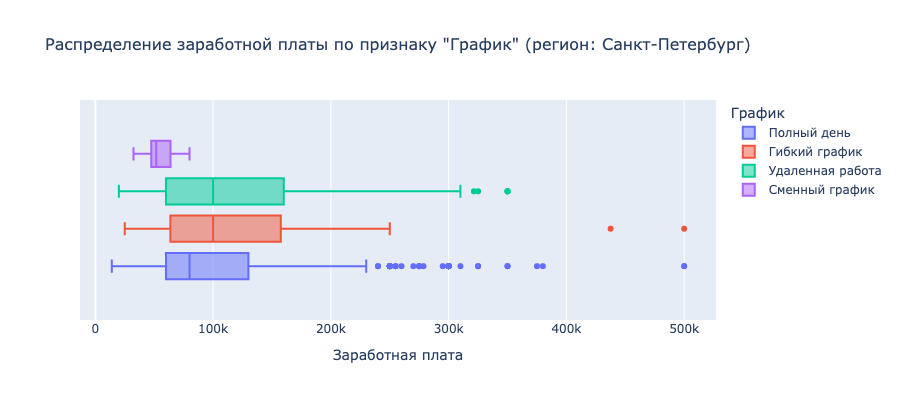

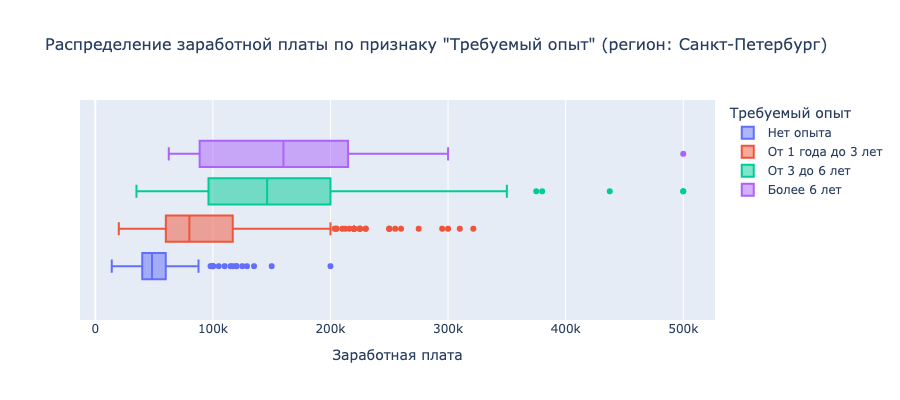

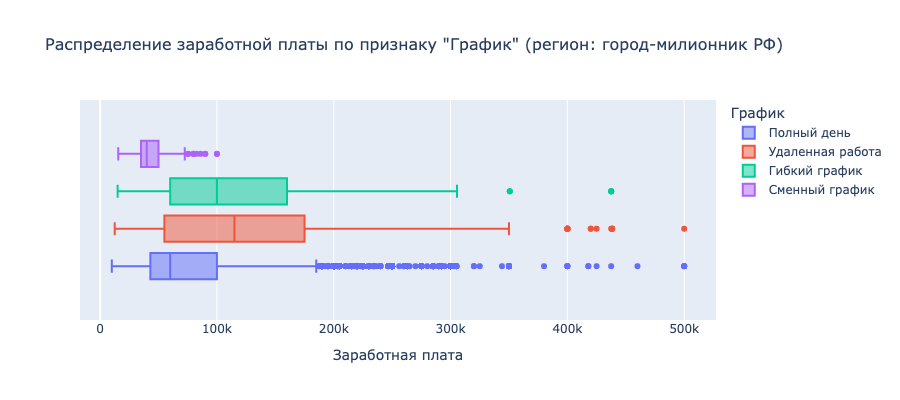

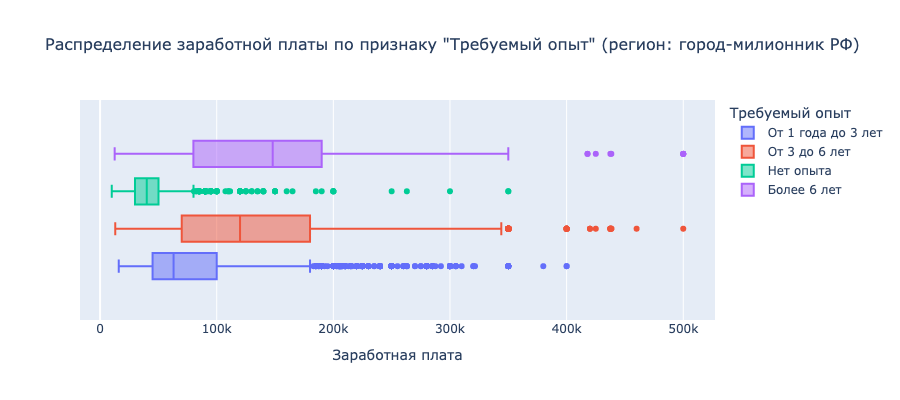

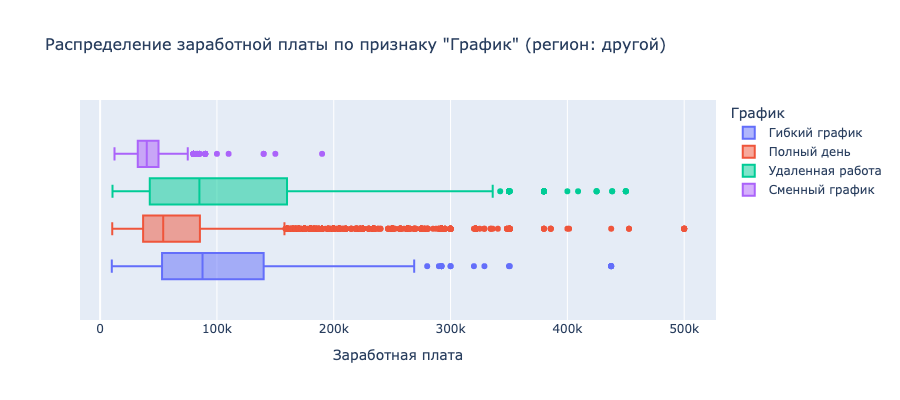

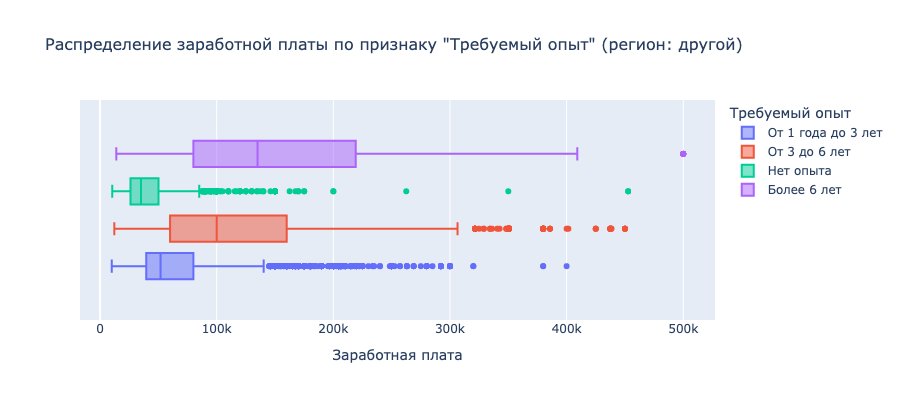

In [76]:
for region in ['Москва', 'Санкт-Петербург', 'город-милионник РФ', 'другой']:
    for col in ['График', 'Требуемый опыт']:
        fig = px.box(
            df_salary[df_salary['Регион'] == region], 
            x='Заработная плата',
            color=col,
            width=900,
            height=400,
            title=f'Распределение заработной платы по признаку "{col}" (регион: {region})'
        )
        fig.update_layout(title_font_size=16)
        fig.show(px_mode)

По результатам визуального анализа коробчатых диаграмм **почистим вручную данные от явных аномалий** (метод Тьюки нам не вполне подходит ввиду того, что из-за особенностей распределений пришлось бы для каждого категории каждого признака подбирать число размахов индивидуально - что ничуть не лучше очистки вручную).

Удалять выбросы по заработной плате требуется только справа. Для этого составим словарь, в который внесем значения верних границ заработной платы для каждой категории *'региона'* и далее для каждой категории признаков *'требуемого опыта'* и *'графика'*:

In [77]:
cleanup = {
    'Москва': {
        'Требуемый опыт': {
            'Более 6 лет': 450_000,
            'От 3 до 6 лет': 430_000,
            'От 1 года до 3 лет': 265_000,
            'Нет опыта': 135_000
        },
        'График': {
            'Полный день': 350_000,
            'Гибкий график': 350_000,
            'Удаленная работа': 400_000,
            'Сменный график': 100_000
        }
    },
    'Санкт-Петербург': {
        'Требуемый опыт': {
            'Более 6 лет': 300_000,
            'От 3 до 6 лет': 350_000,
            'От 1 года до 3 лет': 230_000,
            'Нет опыта': 130_000
        },
        'График': {
            'Полный день': 310_000,
            'Гибкий график': 250_000,
            'Удаленная работа': 310_000,
            'Сменный график': 80_000
        }
    },
    'город-милионник РФ': {
        'Требуемый опыт': {
            'Более 6 лет': 425_000,
            'От 3 до 6 лет': 400_000,
            'От 1 года до 3 лет': 310_000,
            'Нет опыта': 140_000
        },
        'График': {
            'Полный день': 305_000,
            'Гибкий график': 350_000,
            'Удаленная работа': 350_000,
            'Сменный график': 90_000
        }
    },
    'другой': {
        'Требуемый опыт': {
            'Более 6 лет': 410_000,
            'От 3 до 6 лет': 350_000,
            'От 1 года до 3 лет': 300_000,
            'Нет опыта': 150_000
        },
        'График': {
            'Полный день': 300_000,
            'Гибкий график': 300_000,
            'Удаленная работа': 350_000,
            'Сменный график': 90_000
        }
    }
}
for region in cleanup:
    for col in cleanup[region]:
        for cat, upper in cleanup[region][col].items():
            mask = (df_salary[col] == cat) & (df_salary['Заработная плата'] > upper)
            df_salary.loc[mask, ['Заработная плата']] = np.NaN
            
df_salary.sort_values('Заработная плата', inplace=True)

In [78]:
pivot = df_salary.pivot_table(
    values='Заработная плата',
    columns='Требуемый опыт',
    index=['Регион', 'График'],
    aggfunc='mean'
)
pivot = pivot[['Нет опыта', 'От 1 года до 3 лет', 'От 3 до 6 лет', 'Более 6 лет']].round()

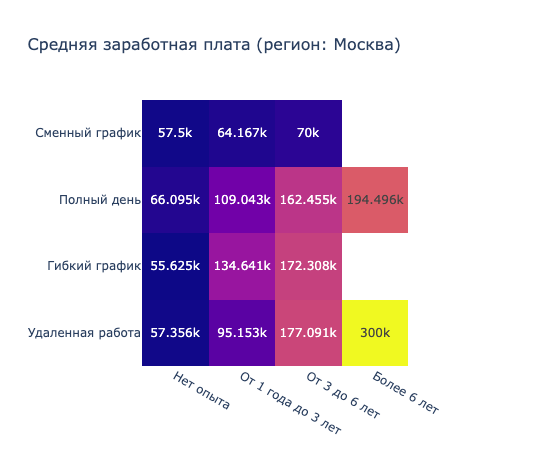

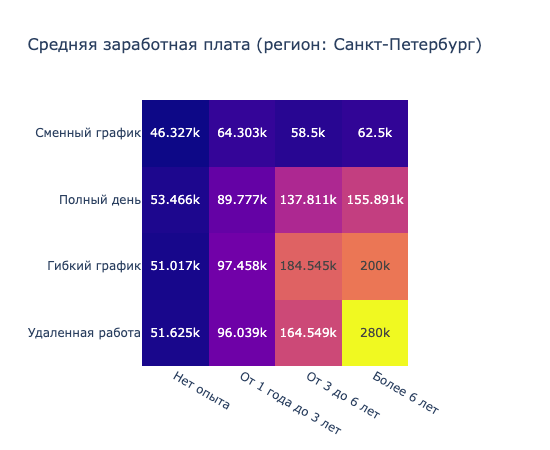

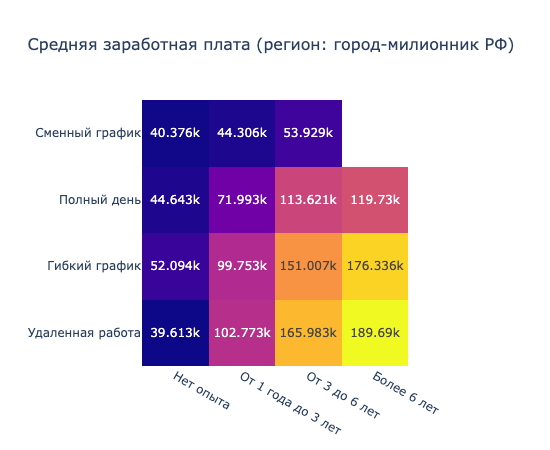

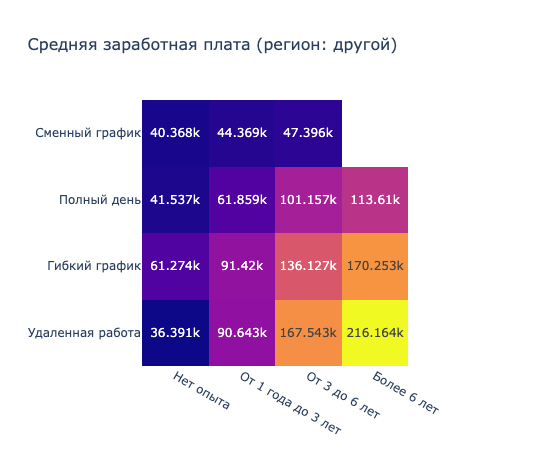

In [79]:
for region in ['Москва', 'Санкт-Петербург', 'город-милионник РФ', 'другой']:
    fig = px.imshow(
        pivot.loc[region].loc[['Сменный график', 'Полный день', 'Гибкий график', 'Удаленная работа']],
        width=550,
        height=450,
        range_color=[0, 350_000],
        text_auto=True,
        title=f'Средняя заработная плата (регион: {region})'
    )
    fig.update_layout(plot_bgcolor='white', yaxis_title=None, xaxis_title=None, title_font_size=16)
    fig.update_traces(dict(showscale=False, coloraxis=None))
    fig.show(px_mode)

Итак, независимо от региона вакансии, **наибольшая заработная плата для соискателей с опытом** обещается работодателями в вакансиях с гибким графиком и удаленной работой. Далее следуют вакансии с рабочим графиком на полный день. А самый низкий уровень заработной платы - для сменного графика.

А вот **для соискателей без опыта работы** результаты несколько другие: в Москве и Питере наибольшая зарплата для новичков соответствует полному рабочему дню; в других городах наибольшая зарплата доступна при гибком рабочем графике.

**Оплата труда по сменному графику с увеличением опыта работы расчет медленнее** (во всех регионах) по сравлению с другими рабочими графиками.

***

### Выводы по результатам детального анализа вакансий

1. В топ регионов по количеству вакансий входят крупнейшие города России и некоторых стран СНГ (Белоруссия, Казахстан, Узбекистан). **В топ-5: Москва, Санкт-Петербург, Минск, Новосибирск, Алматы**.

2. Лишь **в половине вакансий указана заработная плата**.

3. **Средние значения нижней и верхней границы зарплатной вилки по всем вакансиям: 71 тыс.руб и 111 тыс.руб**. Для построения модели прогнозирования величиы заработной потребуется создать признаки средних значений зарплатной вилки в разрезе категории региона вакансии (и, вероятно, работодателя), требуемого опыта, специальности (должности) и типа занятости.

4. Наиболее востребованым среди работодателей сочетанием рабочего графика и типа занятости традиционно является **полный день / полная занятость**.

5. В качестве требования к опыту соискателей работодатели **чаще всего указывают категорию опыта "От 1 года до 3 лет"** Также широко востребованы опытные специалисты (от 3 до 6 лет). Около 15% вакансий подойдут для соискателей без опыта работа. А вот категория опыта "более 6 лет" представлена весьма незначительно (менее 3%).

6. **Наибольшие заработные платы** работодатели обещают соискателям в Москве, затем со значительным отставанием следует Санкт-Перербург. Далее идут города-милионники. Cамый низкий показатель у вакансий в городах, отнесенных к категории "другие".

7. **Наибольшая заработная плата для соискателей с опытом** обещается работодателями в вакансиях с гибким графиком и удаленной работой. Далее следуют вакансии с рабочим графиком на полный день. Самый низкий уровень заработной платы - для сменного графика.

# Юнит 5. Анализ работодателей

### 5.1. Какие работодатели находятся на первом и пятом месте по количеству вакансий

Слегка изменим поставленную задачу: **добавим возможность получать работодателей не только на первом и пятом, но и на любых местах**, перечисленных в списке *place_list*:

In [80]:
# Список с местами по количеству вакансий
place_list = [1, 5]

# Сначала сделаем выборку работодателей и количества их вакансий,
# упорядоченную по убыванию количества вакансий
sql = '''
    with x as (
        select 
            e.name as employer,
            count(v.id) as vacancies_count
        from 
            employers as e
            join vacancies as v on v.employer_id = e.id
        group by e.id
        order by vacancies_count desc
    )
    '''

# Теперь добавим строки с нужными местами (по списку)
sql += " union all ".join([f"(select *, {pos} as place from x limit 1 offset {pos - 1})" for pos in place_list])

df = pd_read_sql_query(sql, conn)
display(df)

for i in range(df.shape[0]):
    employer = df.loc[i, ['employer']][0]
    place = df.loc[i, ['place']][0]
    print(f"На {place} месте по количеству вакансий - {employer}")

,employer,vacancies_count,place
0,Яндекс,1933,1
1,Газпром нефть,331,5


На 1 месте по количеству вакансий - Яндекс
На 5 месте по количеству вакансий - Газпром нефть


### 5.2. Количество работодателей и вакансий для каждого региона

In [81]:
sql = '''
    /* Создадим две выборки:
    
    1. Информация о количестве вакансий для каждого региона,
    существующего в таблице areas;
    
    2. Информация о количестве работодателей для каждого региона,
    существующего в таблице areas.
    
    Затем полученные выборки объединим (по ключу региона) и вернем
    в качестве результата */
    
    select
        region,
        vacancies_count,
        employers_count
    from
        ( /* Выборка с количеством вакансий по регионам */
        select
            a.id as area_id,
            a.name as region,
            count(v.id) as vacancies_count
        from
            areas as a
            left join vacancies as v on v.area_id = a.id
        group by
            a.id  
        ) as vac
        
        join
        
        ( /* Выборка с количеством работодателей по регионам */
        select
            a.id as area_id,
            count(e.id) as employers_count
        from
            areas as a
            left join employers as e on e.area = a.id
        group by
            a.id    
        ) as emp on emp.area_id = vac.area_id
        
    order by 2 desc, 3 desc
'''

df = pd_read_sql_query(sql, conn)
display(df.head())

,region,vacancies_count,employers_count
0,Москва,5333,5864
1,Санкт-Петербург,2851,2217
2,Минск,2112,1115
3,Новосибирск,2006,573
4,Алматы,1892,721


Важно отметить, что в этой выборке для каждого региона приводится количество работодателей-резидентов, а не работодателей, опубликовавших вакансии в данном регионе. Таким образом, в полученной таблице отсутствует взаимосвязь количества вакансий и количества работодателей.

In [82]:
# Среди регионов, в которых нет вакансий, найдём тот, в котором наибольшее количество работодателей
df[df['vacancies_count'] == 0].sort_values(['employers_count'], ascending=False).iloc[0, :]

region             Россия
vacancies_count         0
employers_count       410
Name: 769, dtype: object

### 5.3. Количество регионов, в которых работодатели публикуют свои вакансии (для **каждого** работодателя)


In [83]:
sql = '''
    select e.name as employer, count(*) as number_of_regions
    from (
    
        /* Во внутренней выборке для каждого id работодателя 
        будет столько записей, в скольких регионах он разместил вакансии */
        
        select employer_id
        from vacancies
        group by employer_id, area_id
        ) as x
        join employers as e on e.id = employer_id
    
    /* Теперь, сгруппировав внутреннюю выборку по работодтелю,
    можно получить искомое количество регионов для каждого работодателя */
    
    group by employer_id, e.name
    order by 2 desc
    '''
df = pd_read_sql_query(sql, conn)
display(df.head())

,employer,number_of_regions
0,Яндекс,181
1,Ростелеком,152
2,Спецремонт,116
3,Поляков Денис Иванович,88
4,ООО ЕФИН,71


### 5.4. Запрос для подсчёта количества работодателей, у которых не указана сфера деятельности. 

In [84]:
sql = '''
    select count(*)
    from 
        employers as e
        left join employers_industries as ei on ei.employer_id = e.id
    where ei.employer_id is null
    order by 1 desc
    '''
df = pd_read_sql_query(sql, conn)
print(f"В базе присутствует {df.iloc[0, 0]} работодателей, не указавших ни одной сферы деятельности")

В базе присутствует 8419 работодателей, не указавших ни одной сферы деятельности


Более трети работодателей не указали в своем профиле ни одной сферы детятельности.

### 5.5. Название компании, находящейся на третьем месте в алфавитном списке (по названию) компаний, у которых указано четыре сферы деятельности

In [85]:
sql = '''
    select 
        e.name
    from
        employers_industries as ei
        join employers as e on e.id = ei.employer_id
    group by
        ei.employer_id, e.name
    having
        count(ei.industry_id) = 4
    order by 1
    limit 1 offset 2
    '''
df = pd_read_sql_query(sql, conn)
print(f'Компания "{df.iloc[0, 0]}" - третья по алфавиту среди компаний, у которых указано четыре сферы деятельности')

Компания "2ГИС" - третья по алфавиту среди компаний, у которых указано четыре сферы деятельности


### 5.6. У какого количества работодателей в качестве сферы деятельности указана "Разработка программного обеспечения"


In [86]:
sql = '''
    select count(*)
    from
        employers_industries as ei
        join industries as i on i.id = ei.industry_id
    where
        i.name = 'Разработка программного обеспечения'
    '''
df = pd_read_sql_query(sql, conn)
print(f"{df.iloc[0, 0]} компаний указали в сферах деятельности разработку программного обеспечения")

3553 компаний указали в сферах деятельности разработку программного обеспечения


### 5.7. Список регионов-миллионников, в которых представлены вакансии компании "Яндекс"

Список должен быть представлен вместе с количеством вакансий Яндекса в каждом из этих регионов.
Также добавим строку `Total` с общим количеством вакансий компании. Результат отсортируйте по возрастанию количества.

Список городов-милионников возьмем [отсюда](https://ru.wikipedia.org/wiki/Города-миллионеры_России#Список_городов-миллионеров): 

In [87]:
import requests
from bs4 import BeautifulSoup

# Получим содержимое интернет-страницы, на которой есть таблица с городами-милионниками
url = 'https://ru.wikipedia.org/wiki/Города-миллионеры_России#Список_городов-миллионеров'
response = requests.get(url)

# С помощью инспектора контента в браузере заранее выяснили, 
# под каким тегом и классом находится нужная нам таблица с названиями городов.
# Названия городов даны в виде ссылок и отмечены тегом <a>.
# Используя свойство названия города, заключающееся в том, что имя собсвтенное
# начинается с заглавной буквы, отфильтруем "мусорную" информацию
page = BeautifulSoup(response.text, 'html.parser')
mln_cities = tuple(a.text for a in page.find('table', class_="standard sortable").find_all('a')  if a.text[0].isupper())

print("Перечень городов-миллионников, полученный из веб-страницы:")
display(mln_cities)

Перечень городов-миллионников, полученный из веб-страницы:


('Москва',
 'Санкт-Петербург',
 'Новосибирск',
 'Екатеринбург',
 'Казань',
 'Нижний Новгород',
 'Красноярск',
 'Челябинск',
 'Самара',
 'Уфа',
 'Ростов-на-Дону',
 'Омск',
 'Краснодар',
 'Воронеж',
 'Пермь',
 'Волгоград')

In [88]:
sql = f'''
    /* Сделаем выборку по городам-милионникам
    и количеству вакансий в них от Яндекса */
    
    with x as (
        select
            a.name as region,
            count(*) as vacancies_count
        from
            vacancies as v
            join employers as e on v.employer_id = e.id
            join areas as a on v.area_id = a.id
        group by
            v.area_id, a.name, e.id
        having
            a.name in {mln_cities} and e.name = 'Яндекс'
        )
    select *
    from x
    
    /* Подцепим строку с суммарным количеством вакансий в выборке */
    union all
    
    select
        'Total',
        sum(vacancies_count)
    from x
        
    order by 2
    '''
df = pd_read_sql_query(sql, conn)
df

,region,vacancies_count
0,Омск,21.0
1,Челябинск,22.0
2,Красноярск,23.0
3,Волгоград,24.0
4,Ростов-на-Дону,25.0
5,Казань,25.0
6,Пермь,25.0
7,Уфа,26.0
8,Самара,26.0
9,Краснодар,30.0


Примерно четверть вакансий "Яндекса" приходится на города-миллионники Российской Федерации.

### 5.8. Дополнительные исследования

#### 5.8.1. Сферы деятельности с самыми высокоплачиваемыми вакансиями

Получим топ-50 сфер деятельности работодателей по величине обещаемой в вакансиях заработной платы.

В базе присутствует много сфер деятельности, в названиях которых в скобках указано уточняющее направление: например *'Агрохимия (производство)'*, *'Агрохимия (продвижение)'*. Для уменьшения количества одинкаовых сфер деятельности в нашем рейтинге уберем из названий скобки и содерждимое внутри них.

In [89]:
sql = '''
    select 
        /* название сферы деятельности без уточнения в скобках */
        regexp_replace(i.name, ' (\(.*\))', '') as industry,
        
        /* средняя зарплата, соответствующая сфере деятельности */
        round(avg(coalesce((v.salary_from + v.salary_to) / 2, v.salary_from, v.salary_to))) as salary,
        
        /* количество вакансий от работодателей, работающих в сфере деятельности */
        count(distinct v.employer_id) as employers_count,
        
        /* количество работодателей, работающих в сфере деятельности */
        count(distinct v.id) as vacancies_count
    from
        industries as i
        join employers_industries as ei on ei.industry_id = i.id
        join vacancies as v on v.employer_id = ei.employer_id
    where
        v.salary_from is not null or v.salary_to is not null
    group by 
        industry
    order by 2 desc
    limit 100
    '''
df_top_industries = pd_read_sql_query(sql, conn)
df_top_industries.head()

,industry,salary,employers_count,vacancies_count
0,Агрохимия,359267.0,7,17
1,Игорный бизнес,191905.0,4,20
2,Зоомагазин,167613.0,8,31
3,Кадровые агентства,144530.0,211,711
4,"Лакокрасочная продукция, сырье",134881.0,19,35


По результатам первого запроса соискатели могут рассчитывать на наибольшую заработную плату в компаниях, работающих в сферах агрохимии, игорного бизнеса, товаров для животных, HR, лакокрасочной продукции и др..

Однако первый **запрос не учитывает, насколько широко сфера деятельности посредством работодателей представлена в вакансиях**. Поэтому, например, второе место в топе занимает *'Игорный бизнес'*, хотя данная сфера деятельности соответствует всего 4 работадателям.

Составим новый запрос поставим **дополнительное условие: будем считать только те сферы деятельности, которые представлены пятьюдесятью или большим количеством работодателей**, опубликовавших вакансии и указавших заработную плату:

In [90]:
sql = '''
    select 
        /* название сферы деятельности без уточнения в скобках */
        regexp_replace(i.name, '(\(.*\))', '') as industry,
        
        /* средняя зарплата, соответствующая сфере деятельности */
        round(avg(coalesce((v.salary_from + v.salary_to) / 2, v.salary_from, v.salary_to))) as salary,
        
        /* количество вакансий от работодателей, работающих в сфере деятельности */
        count(distinct v.employer_id) as employers_count,
        
        /* количество работодателей, работающих в сфере деятельности */
        count(distinct v.id) as vacancies_count
    from
        industries as i
        join employers_industries as ei on ei.industry_id = i.id
        join vacancies as v on v.employer_id = ei.employer_id
    where
        v.salary_from is not null or v.salary_to is not null
    group by 
        industry
    having
        /* дополнительноу условие на количество работодателей, представляющих сферу деятельности */
        count(distinct v.employer_id) >= 50
    order by 2 desc
    limit 100
    '''
df_top_industries = pd_read_sql_query(sql, conn)
df_top_industries.head()

,industry,salary,employers_count,vacancies_count
0,Кадровые агентства,144530.0,211,711
1,Финансово-кредитное посредничество,117714.0,97,192
2,Разработка программного обеспечения,117659.0,1654,4572
3,"Дорожно-строительная техника, сельскохозяйстве...",115570.0,50,128
4,"Бытовая химия, парфюмерия, косметика",110696.0,68,158


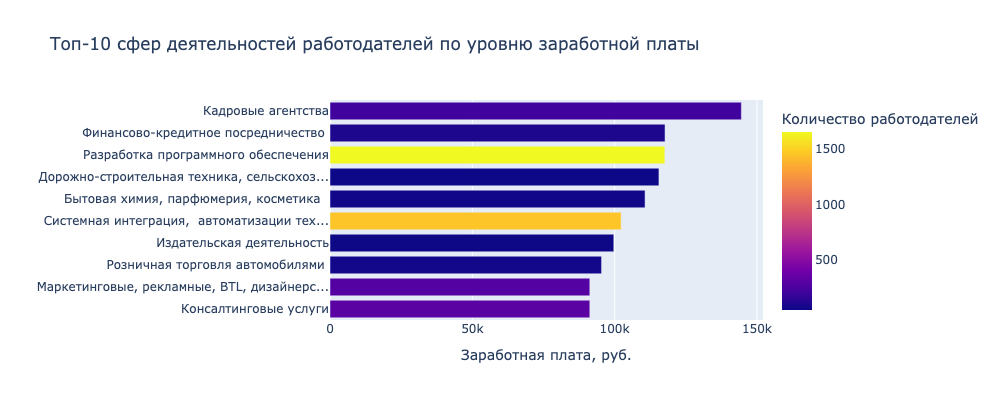

In [105]:
df_top_industries['industry'] = df_top_industries['industry'].apply(lambda x: x[:40] + '...' if len(x) > 40 else x)
fig = px.bar(
    df_top_industries.iloc[9::-1],
    y='industry',
    x='salary',
    color='employers_count',
    width=1000,
    height=400,
    title="Топ-10 сфер деятельностей работодателей по уровню заработной платы",
    labels={
        'salary': 'Заработная плата, руб.', 
        'employers_count': 'Количество работодателей', 
        'industry': ''
    }
)
fig.show(px_mode)

***

### Выводы по результатам анализа работодателей

1. **Лидером среди работодателей** как по количеству вакансий (*1933*), так и по количеству охваченных регионов (*181*) является **компания "Яндекс"**. Четверть вакансий Яндекса размещена в городах-милионниках России.
2. **Москва, Санкт-Петербург и Минск** возглавляют рейтинг регионов как по количеству вакансий, так и по числу работодателей-резидентов.
3. В базе данных присутствуют работодатели, указавшие в качестве места своего нахождения регионы, которые не используются на hh.ru в качестве локации вакансии - например, *Россия*.
4. **Для трети работодателей (36 %) отсутствует информация о сферах деятельности**.
5. **Наиболее привлекательными сферами деятельности** компаний по уровню предлагаемой ими зароботной платы в ИТ-вакансиях являются:
* Кадровые агентства
* Финансово-кредитное посредничество
* Разработка программного обеспечения
* Дорожно-строительная и сельскохяйственная техника
* Бытовая химия, парфюмерия и косметика
* Системная интеграция и автоматизация

## Юнит 6. Предметный анализ

### 6.1. Сколько вакансий имеет отношение к данным?

Считаем, что вакансия имеет отношение к данным, если в её названии содержатся слова 'data' или 'данн'.

In [92]:
sql = '''
    select count(*)
    from vacancies
    where lower(name) like '%data%' or lower(name) like '%данн%'
    '''
df = pd_read_sql_query(sql, conn)

print(f"{df.iloc[0, 0]} вакансий из базы имеет отношение к данным")

1771 вакансий из базы имеет отношение к данным


### 6.2. Сколько вакансий, подходящих для начинающего дата-сайентиста? 
Будем считать вакансиями для дата-сайентистов такие, в названии которых есть хотя бы одно из следующих сочетаний:
* 'data scientist'
* 'data science'
* 'исследователь данных'
* 'ML' (здесь не нужно брать вакансии по HTML)
* 'machine learning'
* 'машинн%обучен%'

** В следующих заданиях мы продолжим работать с вакансиями по этому условию.*

Считаем вакансиями для специалистов уровня Junior следующие:
* в названии есть слово 'junior' *или*
* требуемый опыт — Нет опыта *или*
* тип трудоустройства — Стажировка.
 

In [93]:
sql = '''
    select
        count(*)
    from
        vacancies
    where
        (
        lower(name) like '%data scientist%'  or
        lower(name) like '%data science%' or
        lower(name) like '%исследователь данных%'  or
        (name like '%ML%' and name not like '%HTML%') or
        lower(name) like '%machine learning%'  or
        lower(name) like '%машинн%обучен%'
        )
        and
        (
        lower(name) like '%junior%' or
        experience = 'Нет опыта' or
        lower(employment) like '%стажировка%'
        )
        
    '''
df = pd_read_sql_query(sql, conn)
print("Количество вакансий в базе для начинающих специалистов Data Science:", df.iloc[0, 0])

Количество вакансий в базе для начинающих специалистов Data Science: 51


Посчитаем также **общее количество вакансий по DS**:

In [94]:
sql = '''
    select
        count(*)
    from
        vacancies
    where
        lower(name) like '%data scien%' or
        lower(name) like '%исследователь данных%'  or
        (name like '%ML%' and name not like '%HTML%') or
        lower(name) like '%machine learning%'  or
        lower(name) like '%машинн%обучен%'       
    '''
df = pd_read_sql_query(sql, conn)
print("Количество вакансий Data Science:", df.iloc[0, 0])

Количество вакансий Data Science: 482


### 6.3. В скольких вакансиях для DS в качестве ключевого навыка указан SQL или postgres?

In [95]:
sql = '''
    select
        count(*)
    from
        vacancies
    where
        (
        lower(name) like '%data scientist%' or
        lower(name) like '%data science%' or
        lower(name) like '%исследователь данных%' or
        (name like '%ML%' and name not like '%HTML%') or
        lower(name) like '%machine learning%' or
        lower(name) like '%машинн%обучен%'
        )
        and
        (
        key_skills ilike '%SQL%' or
        key_skills ilike '%postgres%'
        )
    '''
df = pd_read_sql_query(sql, conn)
print("Количество вакансий в базе для специалистов DS с навыками SQL или postgres:", df.iloc[0, 0])

Количество вакансий в базе для специалистов DS с навыками SQL или postgres: 201


### 6.4. Количество вакансий DS, в которых в качестве ключевого навыка указан Python.

In [96]:
sql = '''
    select
        count(*)
    from
        vacancies
    where
        (
        lower(name) like '%data scientist%' or
        lower(name) like '%data science%' or
        lower(name) like '%исследователь данных%' or
        (name like '%ML%' and name not like '%HTML%') or
        lower(name) like '%machine learning%' or
        lower(name) like '%машинн%обучен%'
        )
        and
        (
        key_skills ilike '%python%' or
        key_skills ilike '%пайтон%'
        )
    '''
df = pd_read_sql_query(sql, conn)
print("Количество вакансий в базе для специалистов DS с навыком Python:", df.iloc[0, 0])

Количество вакансий в базе для специалистов DS с навыком Python: 351


### 6.5. Сколько ключевых навыков в среднем указывают в вакансиях для DS?

Ответ округлить до двух знаков после точки-разделителя.

Для подсчета среднего количества указываемых навыков воспользуемся тем, что в поле *'vacancies.key_skills'* нываки разделены символом табуляции. Примем, что количество навыков в каждом поле равно количеству табуляций + 1:

In [97]:
sql = '''
    /* Количество табуляций в строке = длина исходной строки минус длина строки с удаленными табуляции */
    
    select round(avg(CHAR_LENGTH(key_skills) - CHAR_LENGTH(REPLACE(key_skills, '\t', '')) + 1), 2)
    from vacancies
    where
        (
        lower(name) like '%data scientist%' or
        lower(name) like '%data science%' or
        lower(name) like '%исследователь данных%' or
        (name like '%ML%' and name not like '%HTML%') or
        lower(name) like '%machine learning%' or
        lower(name) like '%машинн%обучен%'
        )
    '''
df = pd_read_sql_query(sql, conn)
print(f"В среднем в вакансиях для DS указывают {df.iloc[0,0]} ключевых навыков")

В среднем в вакансиях для DS указывают 6.41 ключевых навыков


### 6.6. Какую зарплату для DS в **среднем** указывают для каждой категории требуемого опыта. 

1. Рассматриваем только вакансии, у которых заполнено хотя бы одно из двух полей с зарплатой.
2. Если заполнены оба поля с зарплатой, то считаем зарплату по каждой вакансии как сумму двух полей, делённую на 2. Если заполнено только одно из полей, то его и считаем зарплатой по вакансии.

Выясните, на какую зарплату в среднем может рассчитывать дата-сайентист с опытом работы от 3 до 6 лет. Результат округлите до целого числа. 

In [98]:
sql = '''
    select
        experience,
        round(avg(salary)) as ds_salary
    from
    (
        select
            experience,
            coalesce((salary_from + salary_to) / 2, salary_from, salary_to) as salary
        from 
            vacancies as v
        where 
            (salary_from is not null or salary_to is not null)
            and
            (
            lower(name) like '%data scientist%' or
            lower(name) like '%data science%' or
            lower(name) like '%исследователь данных%' or
            (name like '%ML%' and name not like '%HTML%') or
            lower(name) like '%machine learning%' or
            lower(name) like '%машинн%обучен%'
            )
    ) as x
    group by experience
    '''
df_ds_salary = pd_read_sql_query(sql, conn)
display(df_ds_salary)

,experience,ds_salary
0,Нет опыта,74643.0
1,От 1 года до 3 лет,139675.0
2,От 3 до 6 лет,243115.0


### 6.7. Дополнительные исследования

#### 6.7.1. Ключевые навыки для работы дата-сайентистом

Получим датафрейм с информацией по всем вакансиям DS:

In [99]:
from collections import Counter

sql = '''
    select 
        v.name as vacancy, 
        v.key_skills as skills,
        v.employment as employment,
        v.schedule as schedule,
        v.experience as experience,
        coalesce((v.salary_from + v.salary_to) / 2, v.salary_from, v.salary_to, null) as salary,
        e.name as employer,
        a.name as region
        
    from
        vacancies as v
        left join employers as e on v.employer_id = e.id
        left join areas as a on a.id = v.area_id
        
    /* берем только вакансии DS */
    where
        lower(v.name) like '%data scien%' or
        lower(v.name) like '%исследователь данных%'  or
        (v.name like '%ML%' and v.name not like '%HTML%' and v.name not like '%QML%') or
        lower(v.name) like '%machine learning%'  or
        lower(v.name) like '%машинн%обучен%'       
    '''
df = pd_read_sql_query(sql, conn)

df['skills'] = df['skills'].apply(lambda x: x.replace('\t', ',') if x else x)
df['employment'] = df['employment'].astype('category')
df['schedule'] = df['schedule'].astype('category')
df['experience'] = df['experience'].astype('category')

print(f"В базе найдено {df.shape[0]} вакансий по профессии Data Sciense.")

В базе найдено 469 вакансий по профессии Data Sciense.


Приведем в порядок "разношерстные" ключевые навыки ("Машинное обучение", "machine learning" -> "ML"  и т.п.). 

Для этого напишем отдельную функцию `cleanup_skills()`, которая будет принимать на вход строку с перечисленными через запятую ключевыми навыкам и затем обрабатывать каждый из них отдельно: название навыка будет проверяться на соответствие одному из "синонимов" (из заранее подготовленного списка `synonyms`) и в случае выявления соответствия заменяться на единое общее название навыка.

После обработки всех навыков из исходной строки фукнция `cleanup_skills()` снова соберет их в единую строку и вернет в качестве результата. 

In [100]:
def cleanup_skills(x: str) -> str:
    if not x:
        return x
    
    x = [skill.strip() for skill in x.split(',')]
    
    # Список синонимов должен быть дополнен для достижения
    # более точных результатов по всей совокупности навыков.
    # Однако, поскольку нас будут интересовать лишь наиболее часто
    # запрашиваемые навыки, а весь проект делается в учебных целях,
    # то на данном этапе и такой список сработает:
    synonyms = [
        (['achine learning', 'ашинное обуч', 'deep lear'], 'ML'),
        (['нейросети', 'нейронные сет', 'neural netw'], 'Нейросети'),
        (['data scien'], 'Data Science'),
        (['анализ данн', 'data analy'], 'Анализ данных')
    ]
    
    # Функция будет искать соответствие одному из синонимов
    # до первого найденного случая. 
    def snm_replace(x: list):
        nonlocal synonyms
        for i in range(len(x)):
            done = False
            for snm_lst, replacement in synonyms:
                for snm in snm_lst:
                    if snm in x[i].lower():
                        x[i] = replacement
                        done = True
                        break
                if done: break
        
    snm_replace(x)    
    
    # В некоторых вакансиях один и тот же навык
    # может быть указан несколько раз 
    # (например, на русском и английском языках или синонимы).
    # Поэтому перед объединением списка навыков в возвращаемую строку
    # "пропустим" его через множество для исключения дубликатов
    return ', '.join(set(x))

# Применим созданую функцию ко всему столбцу 
df['skills'] = df['skills'].apply(cleanup_skills)

Теперь для каждого навыка посчитаем процент его присутвия в вакансиях в разрезе категории опыта:

In [101]:
# Отдельно для каждой категории опыта
# посчитаем проценты присутствия ключевых навыков
# и сохраним в едином датафрейме
df_skills = pd.DataFrame([], columns=['skill', 'percentage', 'experience'])

# Для каждой категории опыта...
for cat in df['experience'].cat.categories: 
    skills = Counter()
    count = df[df['experience'] == cat].shape[0]
    for vac_skills in df[df['experience'] == cat]['skills']:
        if vac_skills:
            # ...посчитаем навыки,
            skills += Counter([skill.strip() for skill in vac_skills.split(',')])
    
    # создадим отдельный датафрейм
    df_cat = pd.DataFrame(
        [[a, round(b / count * 100, 1), cat] for a, b in skills.items()],
        columns=['skill', 'percentage', 'experience']
    )
    
    # и присоединим его (конкатенация по строкам) к общему датафрейму
    df_skills = pd.concat(
        [df_skills, df_cat], 
        ignore_index=True
    )

Построим диаграммы, отображающие Топ-10 необходимых ключевых навыков для каждой категории требуемого опыта:

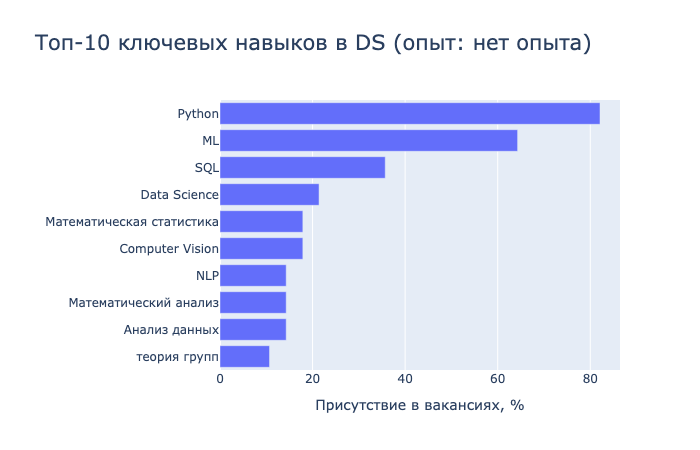

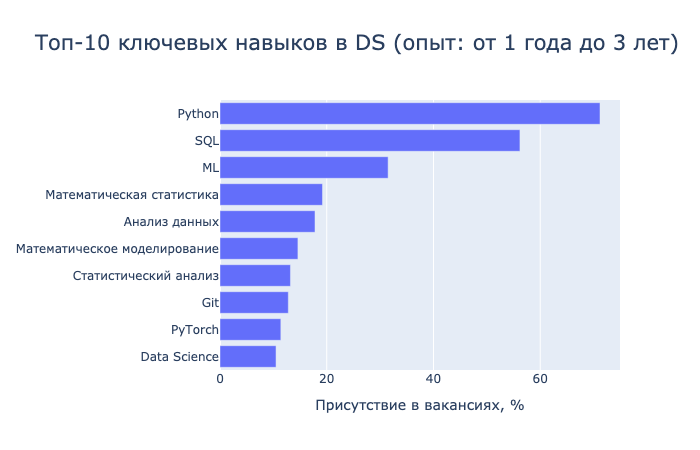

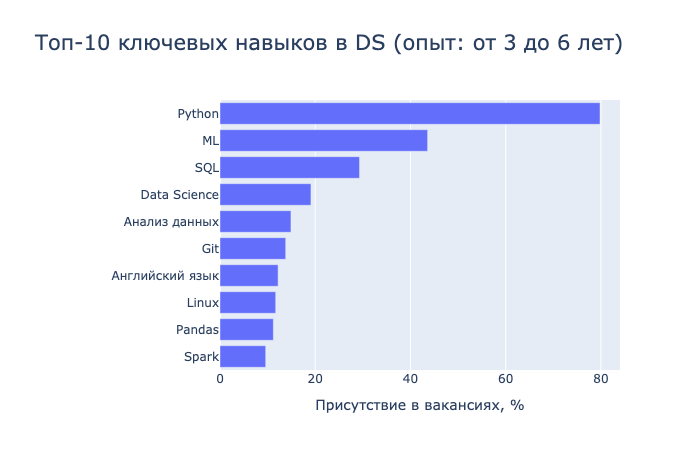

In [102]:
for cat in ['Нет опыта', 'От 1 года до 3 лет', 'От 3 до 6 лет']:
    mask = df_skills['experience'] == cat
    fig = px.bar(
        df_skills[mask].sort_values('percentage', ascending=True)[-10:],
        y='skill',
        x='percentage',
        width=700,
        height=450,
        labels={'skill': '', 'percentage': 'Присутствие в вакансиях, %'},
        title=f'Топ-10 ключевых навыков в DS (опыт: {cat.lower()})',
        orientation='h' 
    )
    fig.update_layout(title_font_size=21, margin=dict(autoexpand=False, l=220))
    fig.show(px_mode)

#### 6.7.2. Заработная плата дата-сайентиста по сравнению с другими айтишниками
В пункте 6.6. мы уже нашли среднюю заработную плату на вакансию дата-сайентиста для каждой категории опыта - хранится в датафрейме `df_ds_salary`.

Найдем теперь среднюю зарплату по всем остальным специальностям и сравним с DS:

In [103]:
sql = '''
    select
        experience,
        round(avg(salary)) as it_salary
    from
    (
        select
            experience,
            coalesce((salary_from + salary_to) / 2, salary_from, salary_to) as salary
        from 
            vacancies as v
        where 
            (salary_from is not null or salary_to is not null)
            and
            not (
            lower(name) like '%data scien%' or
            lower(name) like '%исследователь данных%' or
            (name like '%ML%' and name not like '%HTML%') or
            lower(name) like '%machine learning%' or
            lower(name) like '%машинн%обучен%'
            )
    ) as x
    group by experience
    order by 2
    '''
df_it_salary = pd_read_sql_query(sql, conn)
df_it_salary = df_it_salary.merge(df_ds_salary, on='experience', how='left')

df_it_salary.columns = ['Опыт', 'ИТ-специалист', 'Дата-сайентист']

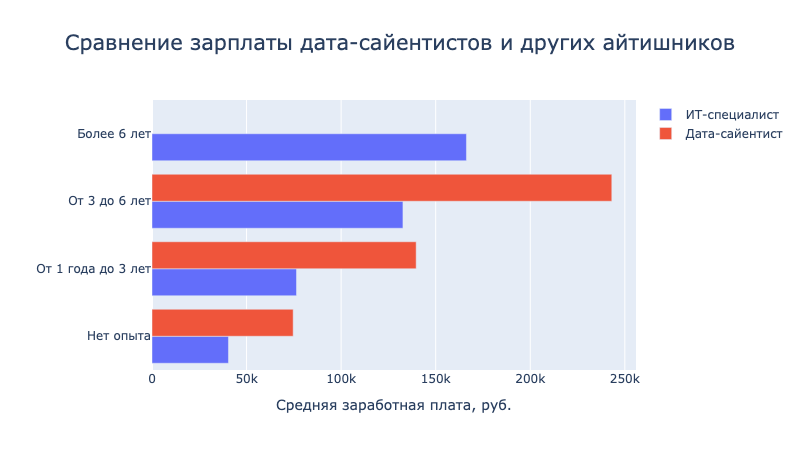

In [104]:
fig = px.bar(
    df_it_salary, 
    x=['ИТ-специалист', 'Дата-сайентист'], 
    y='Опыт', 
    barmode='group', 
    orientation='h',
    labels={'Опыт': '', 'value': 'Средняя заработная плата, руб.', 'variable': ''},
    width=800,
    height=450,
    title='Сравнение зарплаты дата-сайентистов и других айтишников'
)
fig.update_layout(title_x=0.5, title_font_size=21)
fig.show(px_mode)

In [107]:
conn.close()

***

### Выводы по результатам предметного анализа

1. **Вакансии для DS - 1 % от общего количества вакансий в сфере IT**.

2. Работодатели не сильно стремятся брать на работу специалистов без опыта - **всего 50 вакансий для начинаюшего дата-сайентиста**. При этом требования к наывакам новичка не сильно отличаются от тех, которые предъявляют опытным специалистам.

3. В среднем работодатели указываюв в вакансиях по Data Science 6-7 ключевых навыков.

4. **Ключевые навыки дата-сайентиста** (независимо от опыта работы): 
* Python, 
* технологии машинного обучения, 
* SQL, 
* анализ данных. 

   Конечно, перечень требуемых навыков в большинстве ваканcий значительно шире - математика (статистика, анализ, алгоритмы), конкретные библиотеки и пакеты, языки программирования помимо Пайтон. Но именно перечисленные выше навыки являются базой, без которой в любом случае не обойтись.
   
5. **Средняя заработная плата дата-сайентиста почти вдвое выше, чем у других ИТ-специалистов** (во всех представленных категориях опыта работы)

# Общий вывод по проекту

1. **Москва, Санкт-Петербург и Минск** возглавляют рейтинг регионов как по количеству вакансий, так и по числу работодателей-резидентов. Также в топ регионов по количеству вакансий крупнейшие некоторых стран СНГ (Белоруссия, Казахстан, Узбекистан).

2. **Наиболее высокий уровень заработной платы** работодатели обещают соискателям в Москве, затем со значительным отставанием следует Санкт-Перербург. Далее идут города-милионники. Cамый низкий показатель у вакансий в городах, отнесенных к категории "другие". При этом **заработная плата указана лишь в половине вакансий**.

3. В качестве требования к опыту соискателей работодатели **чаще всего указывают категорию опыта "От 1 года до 3 лет"** Также широко востребованы опытные специалисты (от 3 до 6 лет). Около 15% вакансий подойдут для соискателей без опыта работа. А вот категория опыта "более 6 лет" представлена весьма незначительно (менее 3%).

4. Наиболее частым сочетанием рабочего графика и типа занятости традиционно является **полный день / полная занятость**. 

5. При этом  **наибольшая заработная плата для соискателей с опытом** обещается работодателями в вакансиях **с гибким графиком и удаленной работой**. Далее следуют вакансии с рабочим графиком на полный день. Самый низкий уровень заработной платы - для сменного графика.

6. **Наиболее привлекательными сферами деятельности** компаний по уровню предлагаемой ими зароботной платы в ИТ-вакансиях являются:
* Кадровые агентства
* Финансово-кредитное посредничество
* Разработка программного обеспечения
* Дорожно-строительная и сельскохяйственная техника
* Бытовая химия, парфюмерия и косметика
* Системная интеграция и автоматизация

7. **Вакансии для DS - 1 %** от общего количества вакансий в сфере IT.

8. Работодатели не сильно стремятся брать на работу специалистов DS без опыта - **всего 50 вакансий для начинаюшего дата-сайентиста**. При этом требования к наывакам новичка не сильно отличаются от тех, которые предъявляют опытным специалистам.

9. **Ключевые навыки дата-сайентиста** (независимо от опыта работы): 
* Python, 
* технологии машинного обучения, 
* SQL, 
* анализ данных. 

   Конечно, перечень требуемых навыков в большинстве ваканcий значительно шире - математика (статистика, анализ, алгоритмы), конкретные библиотеки и пакеты, языки программирования помимо Пайтон. Но именно перечисленные выше навыки являются базой, без которой в любом случае не обойтись.
   
10. **Средняя заработная плата дата-сайентиста почти вдвое выше, чем у других ИТ-специалистов** (во всех представленных категориях опыта работы)